# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')
for data in [calls, internet, messages, tariffs, users]:
    print(data.info())
del internet['Unnamed: 0']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.D

В таблице internet обнаружен столбец unnamed, который дублирует id. Поэтому его удаляем.
Датасет содержит данные по 500 клиентам, нужно заменить тип данных у столбцов с датой и временем.

In [3]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Заменяем тип данных у столбцов с датой

In [4]:
print('Количество звонков с длительностью, равной нулю:', calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с длительностью, равной нулю: 39613


Посмотрим, как влияют нули в длительности звонков на наше исследование. Можем ли мы их выбросить или же можно их на что-то заменить?

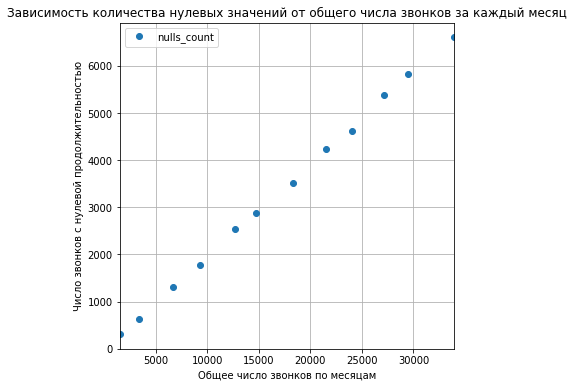

In [5]:
# добавим столбец со значением месяца
calls['month'] = calls['call_date'].dt.month

# построим график зависимости количества нулевых значений от общего числа звонков за каждый месяц
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'], 3)


null_calls.plot(x='id', y= 'nulls_count', style='o', grid=True, figsize=(6, 6))
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой продолжительностью')
_ = plt.title('Зависимость количества нулевых значений от общего числа звонков за каждый месяц')


Можем увидеть линейную зависимость. Так как Мегалайн округляет все в большую сторону, округлим эти "нулевые" звонки в сторону 1.

In [6]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls.loc[calls['duration'] == 0, 'duration'] = 1
calls

,id,call_date,duration,user_id,month,nulls_count
0,1000_0,2018-07-25,1.0,1000,7,1.0
1,1000_1,2018-08-17,1.0,1000,8,1.0
2,1000_2,2018-06-11,3.0,1000,6,NaN
3,1000_3,2018-09-21,14.0,1000,9,NaN
4,1000_4,2018-12-15,6.0,1000,12,NaN
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12,NaN
202603,1499_216,2018-10-18,19.0,1499,10,NaN
202604,1499_217,2018-11-10,11.0,1499,11,NaN
202605,1499_218,2018-10-06,5.0,1499,10,NaN


Теперь исследуем нули в использованных мегабайтах таким же способом.

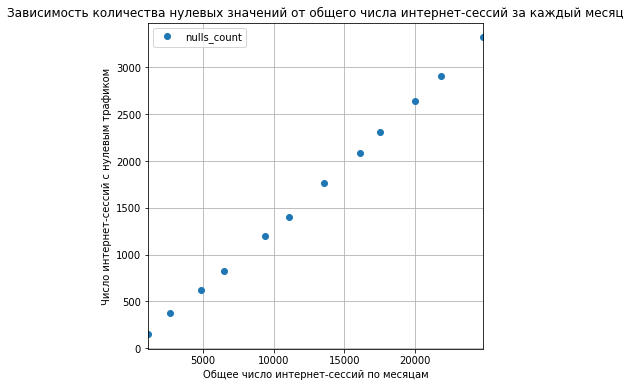

In [7]:
# добавим столбец со значением месяца
internet['month'] = internet['session_date'].dt.month

# построим график зависимости количества нулевых значений от общего числа Интернет-сессий за каждый месяц
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

#sns.relplot(x='id', y='nulls_count', data=null_mb, color='tab:red')
null_mb.plot(x='id', y= 'nulls_count', style='o', grid=True, figsize=(6, 6))
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком')
_ = plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц')

Наблюдаем знакомую линейную зависимость. Также заменим нули на 1.

In [8]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

### Подсчет для каждого пользователя

Найдем для каждого пользователя:

1. количество сделанных звонков и израсходованных минут разговора по месяцам;

2. количество отправленных сообщений по месяцам;

3. объем израсходованного интернет-трафика по месяцам.

In [9]:
# для подсчета при создании сводной таблицы сгенерируем ключ из имени и населенного пункта
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']

# сводная таблица по звонкам
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

# сводная таблица по сообщениям
messages['month'] = messages['message_date'].dt.month
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

# сводная таблица по интернет-трафику
internet['month'] = internet['session_date'].dt.month
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

# объединяем все три сводные таблицы в одну

grouped_data = calls_grouped.merge(messages_grouped, on = ['user_id', 'month'], how='outer')
grouped_data = grouped_data.merge(internet_grouped, on = ['user_id', 'month'], how='outer')
grouped_data.head(15)

duration  calls  messages  mb_used
user_id month                                    
1000    5         164.0   22.0      22.0   2257.0
        6         187.0   43.0      60.0  23262.0
        7         346.0   47.0      75.0  14017.0
        8         418.0   52.0      81.0  14072.0
        9         478.0   58.0      57.0  14583.0
        10        363.0   57.0      73.0  14717.0
        11        344.0   43.0      58.0  14769.0
        12        341.0   46.0      70.0   9829.0
1001    11        444.0   59.0       NaN  18460.0
        12        430.0   63.0       NaN  14059.0
1002    6         118.0   15.0       4.0  10878.0
        7         219.0   26.0      11.0  17615.0
        8         294.0   42.0      13.0  20357.0
        9         217.0   36.0       4.0  16724.0
        10        221.0   33.0      10.0  13913.0

Теперь найдем выручку для каждого пользователя:
вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножаем на значение из тарифного плана; прибавляем абонентскую плату, соответствующую тарифному плану.

In [10]:
# пропущенные значения заменяем на нули
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

# добавим наименование используемого тарифа для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

# функция подсчета выручки с каждого пользователя в месяц
def det_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mb_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

grouped_data['revenue'] = grouped_data.apply(det_revenue, axis=1)
grouped_data.head(10)

duration  calls  messages  mb_used tariff     revenue
user_id month                                                       
1000    5         164.0   22.0      22.0   2257.0  ultra  1950.00000
        6         187.0   43.0      60.0  23262.0  ultra  1950.00000
        7         346.0   47.0      75.0  14017.0  ultra  1950.00000
        8         418.0   52.0      81.0  14072.0  ultra  1950.00000
        9         478.0   58.0      57.0  14583.0  ultra  1950.00000
        10        363.0   57.0      73.0  14717.0  ultra  1950.00000
        11        344.0   43.0      58.0  14769.0  ultra  1950.00000
        12        341.0   46.0      70.0   9829.0  ultra  1950.00000
1001    11        444.0   59.0       0.0  18460.0  smart  1155.46875
        12        430.0   63.0       0.0  14059.0  smart   550.00000

### Анализ данных
Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц

In [11]:
medians = grouped_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='median')
for user_id in users['user_id']:
    medians.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
medians.head(15)

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,345.0,14327.5,65.0,1950.000000,ultra
1001,437.0,16259.5,0.0,852.734375,smart
1002,221.0,17615.0,11.0,990.429688,smart
1003,844.0,11369.0,83.0,1950.000000,ultra
1004,136.5,17831.0,154.5,1950.000000,ultra
1005,609.5,7846.5,49.0,884.500000,smart
1006,365.0,15554.0,0.0,587.890625,smart
1007,490.0,14451.0,26.0,881.843750,smart
1008,350.0,13243.0,56.0,568.000000,smart


Найдем медиану, дисперсию и стандартное отклонение:

In [13]:
grouped_data.dropna(subset=['duration'], inplace=True)
desc_stat = grouped_data.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
desc_stat


duration                             mb_used                \
         median         std            var   median           std   
tariff                                                              
smart     435.0  194.871174   37974.774628  16540.0   5879.795158   
ultra     532.0  325.738740  106105.726823  19324.0  10097.107541   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   3.457199e+07     28.0  28.227876   796.812958  
ultra   1.019516e+08     38.0  47.804457  2285.266143

In [14]:
medians.dropna(subset=['duration'], inplace=True)
desc_stat1 = medians.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
desc_stat1


duration                             mb_used               \
         median         std           var    median          std   
tariff                                                             
smart     453.0  164.614327  27097.876586  16955.00  4181.498288   
ultra     550.5  311.491491  97026.949014  19751.75  8901.975727   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   1.748493e+07     28.5  28.010653   784.596662  
ultra   7.924517e+07     47.5  49.236809  2424.263318

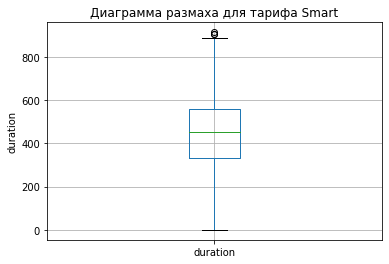

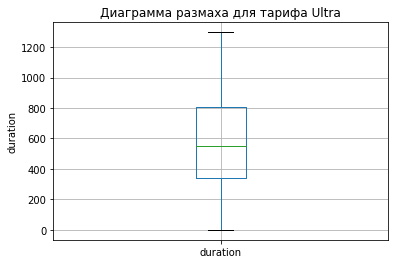

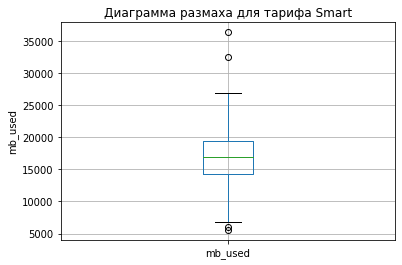

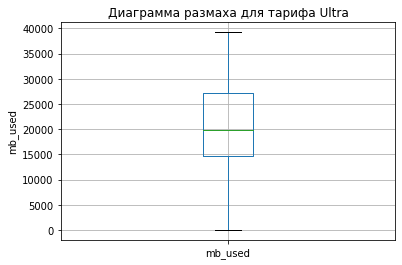

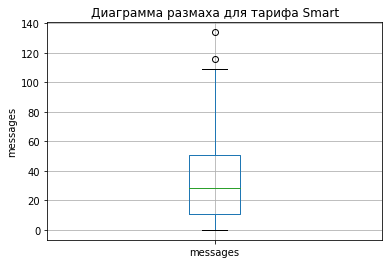

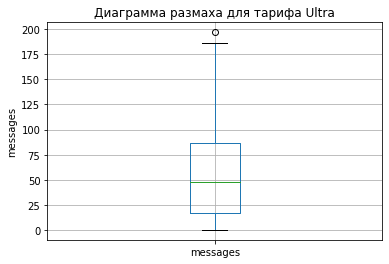

In [13]:
smart1 = medians[medians['tariff'] == 'smart']
ultra1 = medians[medians['tariff'] == 'ultra']

for column in ['duration', 'mb_used', 'messages']: 
    smart1.plot(x="tariff", y=column, kind="box", grid = True)
    plt.ylabel(column)
    plt.title('Диаграмма размаха для тарифа Smart')
    plt.show()
    ultra1.plot(x="tariff", y=column, kind="box", grid = True)
    plt.ylabel(column)
    plt.title('Диаграмма размаха для тарифа Ultra')
    plt.show()

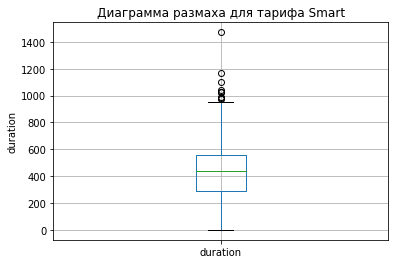

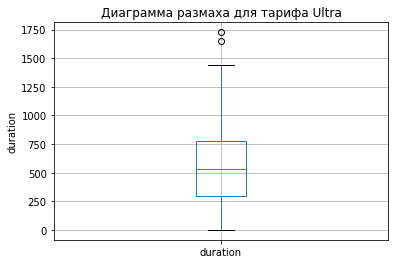

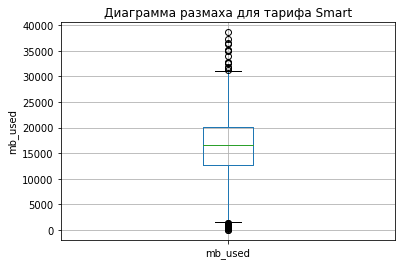

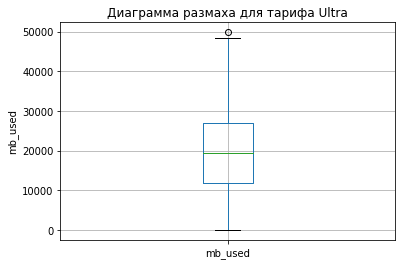

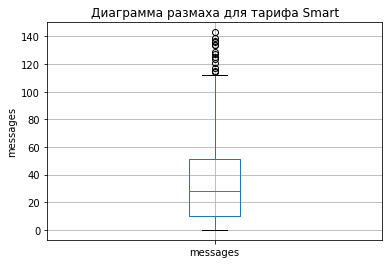

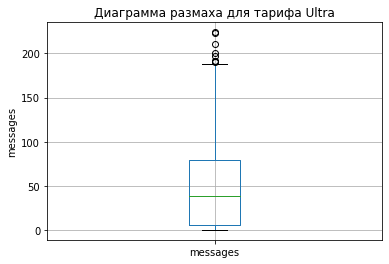

In [15]:
smart2 = grouped_data[grouped_data['tariff'] == 'smart']
ultra2 = grouped_data[grouped_data['tariff'] == 'ultra']

for column in ['duration', 'mb_used', 'messages']: 
    smart2.plot(x="tariff", y=column, kind="box", grid = True)
    plt.ylabel(column)
    plt.title('Диаграмма размаха для тарифа Smart')
    plt.show()
    ultra2.plot(x="tariff", y=column, kind="box", grid = True)
    plt.ylabel(column)
    plt.title('Диаграмма размаха для тарифа Ultra')
    plt.show()

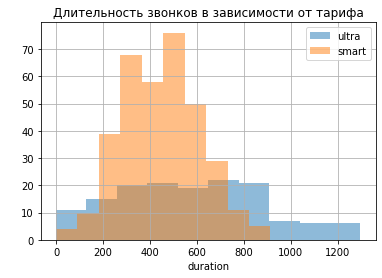

In [14]:
for tariff in ['ultra', 'smart']:
    medians.query('tariff == @tariff')['duration'].plot( kind = 'hist', alpha = 0.5, grid = True)
plt.xlabel('duration')
plt.ylabel(' ')
_ = plt.title('Длительность звонков в зависимости от тарифа')
_ = plt.legend(['ultra', 'smart'])


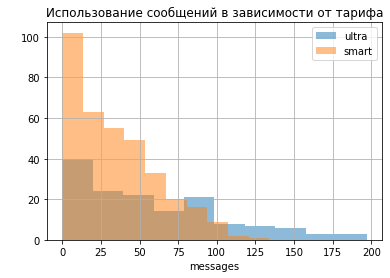

In [15]:
for tariff in ['ultra', 'smart']:
    medians.query('tariff == @tariff')['messages'].plot(kind = 'hist', alpha = 0.5, grid = True)
plt.xlabel('messages')
plt.ylabel(' ')
_ = plt.title('Использование сообщений в зависимости от тарифа')
_ = plt.legend(['ultra', 'smart'])

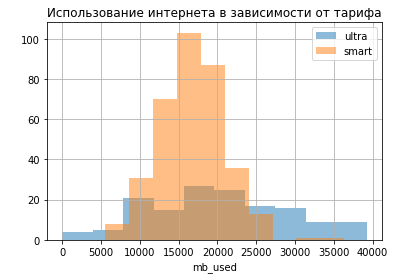

In [16]:
for tariff in ['ultra', 'smart']:
    medians.query('tariff == @tariff')['mb_used'].plot(kind = 'hist', alpha = 0.5, grid = True)
plt.xlabel('mb_used')
plt.ylabel(' ')
_ = plt.title('Использование интернета в зависимости от тарифа')
_ = plt.legend(['ultra', 'smart'])

У пользователей тарифа "Ультра" больше дисперсия по всем показателям, чем у пользователей тарифа "Смарт". Также выбросов в тарифе "Ультра" значительно меньше. Их поведение более разнообразно в плане использования связи.
Можно заметить, что пользователи тарифа Ультра реже на полную используют свои возможности, в то время как пользователям тарифа Смарт не хватает базового пакета услуг.
Продолжительность разговора и использованный интернет-трафик подвержены закону нормального распределения, а количество сообщений - распределению Пуассона.

## Проверка гипотез

H0 — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

H1 — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

α=1% (Чтобы не выкинуть лишних значений, поскольку выборка не очень маленькая)

In [17]:
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = .01

results = st.ttest_ind(
    ultra, 
    smart,
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.4535744400867116e-281
Отвергаем нулевую гипотезу


In [18]:
grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,987.664062
ultra,1950.000000


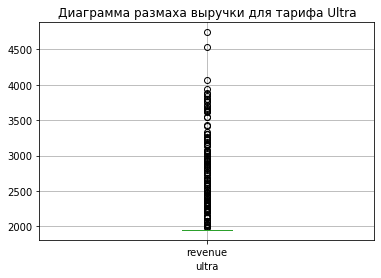

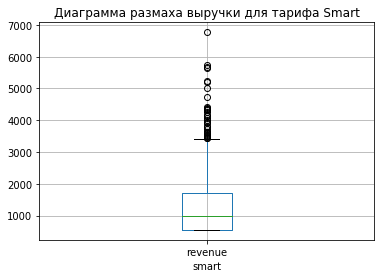

In [19]:
ultra.plot(kind="box", grid = True)
plt.xlabel('ultra')
plt.title('Диаграмма размаха выручки для тарифа Ultra')
plt.show()
smart.plot(kind="box", grid = True)
plt.xlabel('smart')
plt.title('Диаграмма размаха выручки для тарифа Smart')
plt.show()

Средние значения выручки по тарифам различаются почти в 2 раза. Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.
 То есть выручка действительно отличается.


H0 — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

H1 — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

α=1%

In [20]:
# добавим имя города для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions,
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5030013194608627
Не получилось отвергнуть нулевую гипотезу


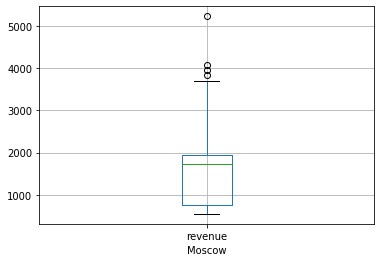

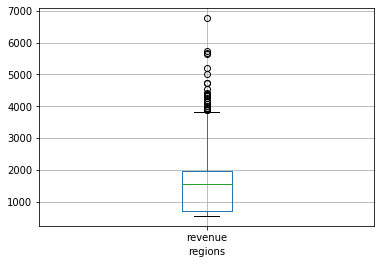

In [21]:
moscow.plot(kind="box", grid = True,)
plt.xlabel('Moscow')
plt.show()
regions.plot(kind="box", grid = True)
plt.xlabel('regions')
plt.show()

А вот доходы в Москве практически не отличаются от доходов в регионах.

По итогам исследования можно сделать вывод, что:
1. Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета: они часто переплачивают.
2. Пользователи тарифа «Ультра», напротив, не используют тарифный пакет в полном объеме.
3. Однако выручка от тарифа "Ультра" все равно выше, чем от тарифа "Смарт"

## Общий вывод

По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 1950 рублей и 988 рублей соответственно (p-значение: 2.4535744400867116e-281, α=1%).

Особенности использования тарифов заключаются в следующем:

1. Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи в среднем доплачивают еще 438 рублей ежемесячно.
2. Пользователи тарифа «Ультра», напротив, не используют тарифный пакет в полном объеме.
3. Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,503) и составляет 188 руб.: 1734 руб. в Москве, а в других населенных пунктах - 1546 руб.